In [1]:
# imports
import re, nltk, gensim, pyLDAvis, nlp
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pprint
pp = pprint.PrettyPrinter()

from tqdm import tqdm

[nltk_data] Downloading package stopwords to C:\Users\Ben
[nltk_data]     Levy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# splitting dataset
def split():
    df = pd.read_csv("all.csv")

    df["text"] = df["text"].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    df["text"] = df["text"].str.replace("[\\n]", "", regex=True)
    df["text"] = df["text"].str.replace("[\\r]", "", regex=True)

    df_male = df[df["text"].str.contains('[0-9][0-9](m|(( y\/o| year old)) (dude|boy|guy|man|male))', regex=True)]
    df_male.to_excel("male.xlsx")
    df_female = df[df["text"].str.contains('[0-9][0-9](f|(( y\/o| year old)) (woman|lady|girl|female))', regex=True)]
    df_female.to_excel("female.xlsx")

    print(len(df_male))
    print(len(df_female))
    print(df_male.head())
    print(df_female.head())

    return df_male, df_female

In [3]:
# loading data
# df_male, df_female = split()
df_male = pd.read_excel("results/male.xlsx").dropna()
df_female = pd.read_excel("results/female.xlsx").dropna()

data_male = df_male.text.tolist()
data_female = df_female.text.tolist()

In [4]:
# cleaning data a bit

# remove emails
data_male = [re.sub(r"\S*@\S*s?", "", i) for i in data_male]

# remove new lines
data_male = [re.sub(r"\s+", " ", i) for i in data_male]

# remove emails
data_female = [re.sub(r"\S*@\S*s?", "", i) for i in data_female]

# remove new lines
data_female = [re.sub(r"\s+", " ", i) for i in data_female]

In [5]:
# tokenizer
def tokenize(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_male_words = list(tokenize(data_male))
data_female_words = list(tokenize(data_female))

In [6]:
# remove stopwords + lemmatize
from nltk.corpus import stopwords
stopwords = stopwords.words("english")

lemmatizer = WordNetLemmatizer()

def remove_stopwords(texts):
    cleaned_texts = []
    for text in texts:
        cleaned = [w for w in text if not w.lower() in stopwords]
        cleaned = [lemmatizer.lemmatize(w) for w in cleaned]
        cleaned_texts.append(cleaned)
    return cleaned_texts

data_male_stopped = remove_stopwords(data_male_words)
data_female_stopped = remove_stopwords(data_female_words)

In [7]:
# create ID dictionary & corpus
id2word_male = corpora.Dictionary(data_male_stopped)
id2word_female = corpora.Dictionary(data_female_stopped)

corpus_male = [id2word_male.doc2bow(text) for text in data_male_stopped]
corpus_female = [id2word_female.doc2bow(text) for text in data_female_stopped]

In [8]:
# ===begin new approach (Gibbs Sampling LDA instead of Variational Bayes===
# setup for MALLET (Gibbs Sampling LDA)
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:\mallet-2.0.8'}) 
mallet_path = r'C:/mallet-2.0.8/bin/mallet.bat' 

In [46]:
def calculate_coherence_gibbs(corpus, texts, num_topics, id2word):
    model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus, num_topics=num_topics,
                                            iterations=1000, id2word=id2word, optimize_interval=1)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence="u_mass")
    return model, coherence_model.get_coherence()

In [47]:
# doing MALLET and optimization for male ---> best: k=45

# test 10-70 topics
coherence_values_male = []
model_list_male = []
for num_topics in tqdm(range(5, 80, 5)):
    model, coherence_value = calculate_coherence_gibbs(corpus_male, data_male_stopped, num_topics, id2word_male)
    model_list_male.append(model)
    coherence_values_male.append(coherence_value)

100%|██████████| 15/15 [12:08<00:00, 48.57s/it]


In [41]:
# doing MALLET and optimization for female ---> best: k=60

# test 5-80 topics
coherence_values_female = []
model_list_female = []
for num_topics in tqdm(range(5, 80, 5)):
    model, coherence_value = calculate_coherence_gibbs(corpus_female, data_female_stopped, num_topics, id2word_female)
    model_list_female.append(model)
    coherence_values_female.append(coherence_value)

100%|██████████| 11/11 [10:27<00:00, 57.02s/it]


[-3.6768549583798302, -4.501415402734394, -5.4523962408087145, -5.4348754122860985, -5.55662639061252, -6.093167943219092, -5.568361241007688, -6.001032496362067, -5.979279339077621, -5.451847795311014, -5.817511985307395, -6.528799833553611, -6.9683663694015365, -6.509830438838745, -6.671921002234703]


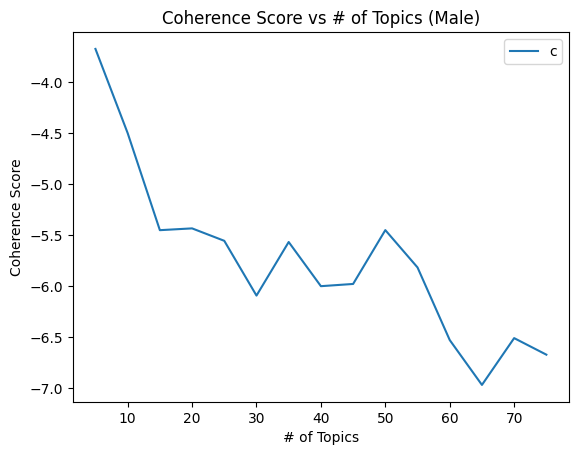

In [49]:
# display MALLET optimization for K for males
start = 5
limit = 80
step = 5
x_key = range(start, limit, step)

print(coherence_values_male)

plt.plot(x_key, coherence_values_male)
plt.title("Coherence Score vs # of Topics (Male)")
plt.xlabel("# of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_male"), loc="best")
plt.show()

[0.43439229260906276, 0.4488607124987392, 0.431974216077739, 0.43703393809943525, 0.4544368229523187, 0.4762361690630048, 0.4695633581842774, 0.4745080804932064, 0.4573299201515156, 0.4852945271121348, 0.4509046941627732]


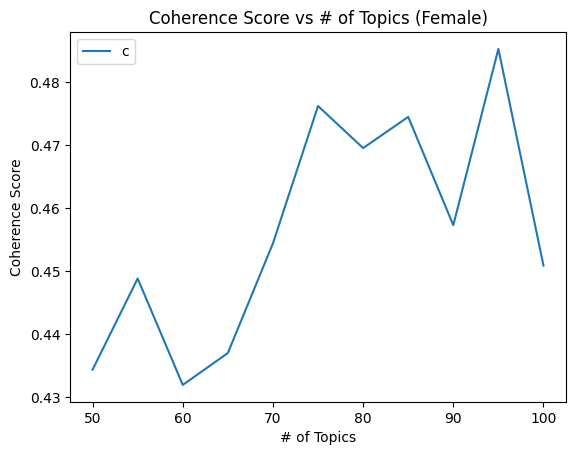

In [42]:
# display MALLET optimization for K for females
start = 50
limit = 105
step = 5
x_key = range(start, limit, step)

print(coherence_values_female)

plt.plot(x_key, coherence_values_female)
plt.title("Coherence Score vs # of Topics (Female)")
plt.xlabel("# of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_female"), loc="best")
plt.show()

In [43]:
# train male and female models for k=45, k=95
model_male = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus_male, num_topics=45,
                                        iterations=1000, id2word=id2word_male, optimize_interval=1)

model_female = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus_female, num_topics=95,
                                        iterations=1000, id2word=id2word_female, optimize_interval=1)

In [44]:
print("===male===")
pp.pprint(model_male.print_topics())
print("===female===")
pp.pprint(model_female.print_topics())

===male===
[(8,
  'nan*"syncope" + nan*"ringing" + nan*"checking" + nan*"checked" + '
  'nan*"beating" + nan*"awareness" + nan*"contribute" + nan*"symptom" + '
  'nan*"monitoring" + nan*"pressure"'),
 (35,
  'nan*"syncope" + nan*"ringing" + nan*"checking" + nan*"checked" + '
  'nan*"beating" + nan*"awareness" + nan*"contribute" + nan*"symptom" + '
  'nan*"monitoring" + nan*"pressure"'),
 (5,
  '0.036*"fiance" + 0.036*"job" + 0.036*"regularly" + 0.036*"hated" + '
  '0.027*"level" + 0.027*"trauma" + 0.027*"pandemic" + 0.027*"stressed" + '
  '0.018*"late" + 0.018*"remember"'),
 (38,
  '0.041*"youre" + 0.031*"wander" + 0.031*"meditation" + 0.031*"emotional" + '
  '0.021*"counting" + 0.021*"bigger" + 0.021*"bring" + 0.021*"subtle" + '
  '0.021*"concentrate" + 0.021*"shot"'),
 (2,
  '0.059*"stuff" + 0.047*"alot" + 0.024*"gross" + 0.024*"eye" + 0.024*"return" '
  '+ 0.024*"decided" + 0.024*"clothes" + 0.024*"stealing" + 0.024*"paycheck" + '
  '0.024*"shopping"'),
 (26,
  '0.067*"class" + 0.03

In [36]:
# export topics to csv for analysis
top_words_per_topic_male = []
for t in range(model_male.num_topics):
    top_words_per_topic_male.extend([(t, ) + x for x in model_male.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic_male, columns=['Topic', 'Word', 'P']).to_csv("topics_male.csv")

top_words_per_topic_female = []
for t in range(model_female.num_topics):
    top_words_per_topic_female.extend([(t, ) + x for x in model_female.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic_female, columns=['Topic', 'Word', 'P']).to_csv("topics_female.csv")

In [33]:
# get topic distributions
from operator import itemgetter

most_probable_topics_male = []

for topics in model_male[corpus_male]:
    # get first most prob
    most_probable_topics_male.append(max(topics, key=itemgetter(1))[0])
    # get second most prob
    topics.remove(max(topics, key=itemgetter(1)))
    most_probable_topics_male.append(max(topics, key=itemgetter(1))[0])
    # get third most prob
    topics.remove(max(topics, key=itemgetter(1)))
    most_probable_topics_male.append(max(topics, key=itemgetter(1))[0])

most_probable_topics_female = []

for topics in model_female[corpus_female]:
    # get first most prob
    most_probable_topics_female.append(max(topics, key=itemgetter(1))[0])
    # get second most prob
    topics.remove(max(topics, key=itemgetter(1)))
    most_probable_topics_female.append(max(topics, key=itemgetter(1))[0])
    # get third most prob
    topics.remove(max(topics, key=itemgetter(1)))
    most_probable_topics_female.append(max(topics, key=itemgetter(1))[0])

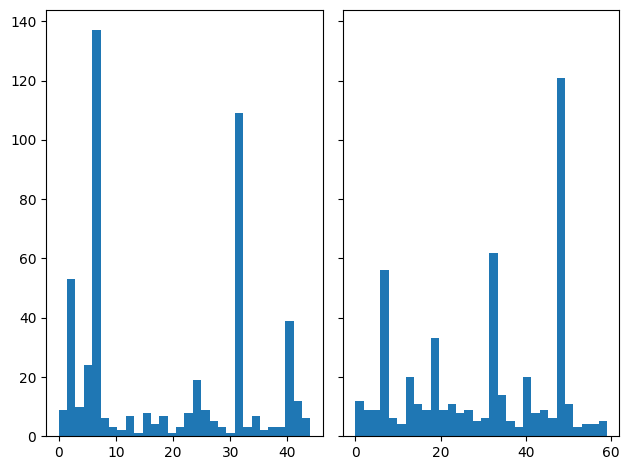

In [34]:
# display topic distributions
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(most_probable_topics_male, bins=30);
axs[1].hist(most_probable_topics_female, bins=30);